## Goal

Write and evaluate a function to conduct fully stratified dataset sampling and/or train test splits.

A fully stratified sample will have the same, or as close as possible to the same distribution of all variable as in the full dataset.

## Plan

1. Start with an initial pesudorandom sample.
2. Compute Kolmogorov–Smirnov statistic for each variable, comparing sample and dataset.
3. Randomly replace observation with fresh draw from dataset
4. Recompute KS statistic.
5. Repeat

## Motivation

During evaluation of the initial gradient boosting model, I noticed that month does not rank highly in terms of feature importance. This observation did not make sense to me - there is clearly a peak wildfire season in California. The monthly trend in number of fires is present in the dataset but does not seem to be used by the model.

One possible explanation for this is the sampling method used. Drawing a few thousand observations randomly from several million might result is skewed distribution of months, making it hard for the model to learn their importance.

The logical conclusion to this line of reasoning was to think the same of all variables - the distribution in the sample should match the distribution in the full dataset if possible.

In [1]:
import pandas as pd

import random

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

from scipy.stats import ks_2samp

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
def k_random_sample(data, k):
    # Takes a data frame and an number of observations
    # returns dataframe containing k from n pseudorandom
    # observations with out replacement
    
    n = len(data)
    indices = random.sample(range(0, n), k)
    return data.iloc[indices]

def stratified_sample(data, n):
    # takes a datafram and a sample size n, returns
    # n observations with positive and negative class
    # frequency matched to orignal data
    
    # split positive and negative datsets up
    ignitions = data[data['ignition'] == 1]
    no_ignitions = data[data['ignition'] == 0]
    
    # Calculate ignition & no ignition sample sizes
    ignition_fraction = len(ignitions) / len(data)
    ignition_sample_size = int((n * ignition_fraction))
    no_ignition_sample_size = int((n * (1 - ignition_fraction)))
    
    # sample data
    no_ignitions_sample = k_random_sample(no_ignitions, no_ignition_sample_size)
    ignitions_sample = k_random_sample(ignitions, ignition_sample_size)

    # combine
    sampled_data = no_ignitions_sample.append(ignitions_sample)
    
    return sampled_data

def make_train_test_sample(dataset, sample_size, train_test_split_ratio, rand_seed):
    # Takes data in dataframe, sample size, train test split
    # ratio and random seed. Samples n datapoints from dataset and then
    # runs stratified train test split on sample.
    # return stratified train test split data
    
    column_names = dataset.columns
    
    if 'weather_bin_time' in column_names:
        dataset = dataset.drop('weather_bin_time', axis=1)
    
    sampled_data = stratified_sample(dataset, sample_size)

    y = sampled_data['ignition']
    X = sampled_data.drop('ignition', axis=1)

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y, 
        test_size=train_test_split_ratio, 
        random_state=rand_seed, 
        stratify=y
    )

    return sampled_data, X_train, X_test, y_train, y_test

def two_sample_density_plot(
    plot_location, 
    parent_data, 
    sample_data, 
    data_type, 
    title, 
    xlabel, 
    ylabel, 
    y_scale
):
    parent_values, parent_base = np.histogram(parent_data[data_type], bins=40)
    sample_values, sample_base = np.histogram(sample_data[data_type], bins=40)
    
    parent_cumulative = np.cumsum(parent_values) / len(parent_data)
    sample_cumulative = np.cumsum(sample_values) / len(sample_data)

    ax[plot_location].plot(parent_base[:-1], (parent_values/len(parent_data)))
    ax[plot_location].plot(sample_base[:-1], (sample_values/len(sample_data)))
    ax[plot_location].tick_params(labelsize=12)
    ax[plot_location].set_title(title, fontsize=18)
    ax[plot_location].set_xlabel(xlabel, fontsize=14)
    ax[plot_location].set_ylabel(ylabel, fontsize=15)
    ax[plot_location].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax[plot_location].set_yscale(y_scale)
    
def cal_KS_total_statistic(data, sample_data, weather_variables):
    
    total_ks = 0
    
    for variable in weather_variables:
        parent_data = np.array(data[variable])
        sample_data = np.array(sample[variable])

        ks_result = ks_2samp(parent_data, sample_data)
        total_ks = total_ks + ks_result[1]
    
    return total_ks

def replace_sample_subset(sample, fraction, data):
        # split sample into positive and negative
        sample_positive = sample[sample['ignition'] == 1]
        sample_negative = sample[sample['ignition'] == 0]
        
        # choose n random indexes to replace in each
        n_positive = len(sample_positive)
        k_positive = int(len(sample_positive)*fraction)
        indices_positive = random.sample(range(0, n_positive), k_positive)
        
        n_negative = len(sample_negative)
        k_negative = int(len(sample_negative)*fraction)
        indices_negative = random.sample(range(0, n_negative), k_negative)
        
        # grab data to replace and remove it from the sample
        data_to_replace_positive = sample_positive.iloc[indices_positive]
        ids_to_replace_positive = data_to_replace_positive.ID
        sample_positive = sample_positive[~sample_positive.ID.isin(ids_to_replace_positive)]
        
        data_to_replace_negative = sample_negative.iloc[indices_negative]
        ids_to_replace_negative = data_to_replace_negative.ID
        sample_negative = sample_negative[~sample_negative.ID.isin(ids_to_replace_negative)]

        # split parent data into positive and negative
        parent_positive = data[data['ignition'] == 1]
        parent_negative = data[data['ignition'] == 0]
        
        # grab replacement points and remove them from the parent dataset
        # note: observations from last round are not in the parent dataset
        new_sample_positive = k_random_sample(parent_positive, k_positive)
        sample_ids_positive = sample_positive.ID
        parent_positive = parent_positive[~parent_positive.ID.isin(sample_ids_positive)]
        
        new_sample_negative = k_random_sample(parent_negative, k_negative)
        sample_ids_negative = sample_negative.ID
        parent_negative = parent_negative[~parent_negative.ID.isin(sample_ids_negative)]
        
        # Add new points to sample and old points back to parent dataset
        sample_positive = sample_positive.append(new_sample_positive)
        sample_negative = sample_negative.append(new_sample_negative)
        sample = sample_positive.append(sample_negative)
        
        parent_positive = parent_positive.append(data_to_replace_positive)
        parent_negative = parent_negative.append(data_to_replace_negative)
        data = parent_positive.append(parent_negative)
        
        return data, sample

In [3]:
data_file = '../data/training_data/1992-1997_training_data_daily_mean.csv'

sample_size = 5000
rand_seed = 42
train_test_split_ratio = 0.3

weather_variables = [
    'weather_bin_month','weather_bin_year','air.sfc', 'air.2m', 
    'apcp', 'crain', 'rhum.2m', 'dpt.2m', 'pres.sfc', 'uwnd.10m', 
    'vwnd.10m', 'veg', 'dlwrf', 'dswrf', 'lcdc','hcdc', 'mcdc', 
    'hpbl', 'prate', 'vis', 'ulwrf.sfc'
]

In [4]:
# Load data
data = pd.read_csv(data_file, low_memory=False)

# Shuffel row order
data = data.sample(frac=1).reset_index(drop=True)

First, let's try the old way of doing it - take a pseudo random sample without replacement, stratifying by label and see if the distributions of weather variables are different in the sample vs the parent dataset.

In [5]:
# Take stratified sample of raw data and do stratified train_test split    
sample, X_train, X_test, y_train, y_test = make_train_test_sample(
    data, 
    sample_size, 
    train_test_split_ratio, 
    rand_seed
)

In [6]:
# For each weather variable, conduct 2 sample KS test to compare
# similarity of distributions

for variable in weather_variables:
    parent_data = np.array(data[variable])
    sample_data = np.array(X_train[variable])
    
    ks_result = ks_2samp(parent_data, sample_data)
    
    print("{} KS test p-value: {}".format(variable, np.round(ks_result[1],3)))

weather_bin_month KS test p-value: 0.634
weather_bin_year KS test p-value: 0.066
air.sfc KS test p-value: 0.4
air.2m KS test p-value: 0.818
apcp KS test p-value: 0.898
crain KS test p-value: 0.996
rhum.2m KS test p-value: 0.705
dpt.2m KS test p-value: 0.797
pres.sfc KS test p-value: 0.796
uwnd.10m KS test p-value: 0.422
vwnd.10m KS test p-value: 0.822
veg KS test p-value: 0.327
dlwrf KS test p-value: 0.698
dswrf KS test p-value: 0.291
lcdc KS test p-value: 0.326
hcdc KS test p-value: 0.821
mcdc KS test p-value: 0.327
hpbl KS test p-value: 0.585
prate KS test p-value: 0.699
vis KS test p-value: 0.565
ulwrf.sfc KS test p-value: 0.553


Does not look like we can outright reject the null for any of the tests.... but we do have some small-ish p-values. Let's take a look at the actual distributions by eye.

In [7]:
# Distribution plotting variables

left  = 0.125  # the left side of the subplots of the figure
right = 0.65   # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.3   # the amount of height reserved for white space between subplots

fig_rows = 7
fig_cols = 3
plot_height = 35
plot_width = 30

plot_locations = [
    (0,0),(0,1),(0,2),
    (1,0),(1,1),(1,2),
    (2,0),(2,1),(2,2),
    (3,0),(3,1),(3,2),
    (4,0),(4,1),(4,2),
    (5,0),(5,1),(5,2),
    (6,0),(6,1),(6,2)
]

data_types = [
    'air.sfc',  # Surface air temp
    'air.2m',   # Air temp. at 2 meters above surface
    'apcp',     # Accumulated precipitation
    'rhum.2m',  # Relative humidity 2 meters above surface
    'dpt.2m',   # Dew point temp. 2 meters above surface
    'pres.sfc', # Pressure at surface
    'uwnd.10m', # u component of wind (positive = from west) 10 meters above surface
    'vwnd.10m', # v component of wind (positive = from south) 10 meters above surface
    'veg',      # Vegitation at surface
    'dlwrf',    # Downward long wave radiation flux at surface
    'dswrf',    # Downward short wave radiation flux at surface
    'lcdc',     # Low cloud area fraction
    'hcdc',     # High cloud area fraction
    'mcdc',     # Medium cloud area fraction
    'hpbl',     # Planetary boundary layer height
    'prate',    # Precipitation rate
    'vis',      # Visibility
    'ulwrf.sfc',# Upward long wave radiation flux at surface
    'lat',
    'lon',
    'weather_bin_month'
]

plot_titles = [
    'Surface Air Temperature',
    'Air Temperature at 2 Meters',
    'Accumulated Precipitation',
    'Relative Humidity at 2 Meters',
    'Dew Point Temperature',
    'Surface Pressure',
    'East-west Component of Wind',
    'North-south Component of Wind',
    'Vegitation Coverage',
    'Downward Long Wave EM Flux',
    'Downward Short Wave EM Flux',
    'Low Height Cloud Coverage',
    'High Height Cloud Coverage',
    'Medium Height Cloud Coverage',
    'Planetary Boundary Layer Height',
    'Precipitation Rate',
    'Visibility',
    'Upward Long Wave EM Flux',
    'Latitude',
    'Longitude',
    'Month'
]

weather_variable_labels = [
    'Temp. (K)',
    'Temp (K)',
    'Precipitation (in.)',
    'Humidity (%)',
    'Temp (K)',
    'Pressure (kPa)',
    'Speed (mph)',
    'Speed (mph)',
    'Coverage (%)',
    'Flux',
    'Flux',
    'Coverage Fraction',
    'Coverage Fraction',
    'Coverage Fraction',
    'Height (m)',
    'Rate',
    'Visibility',
    'Flux',
    'Latitude',
    'Longitude',
    'Month'
]

y_scales = [
    'linear',
    'linear',
    'log',
    'linear',
    'linear',
    'linear',
    'linear',
    'linear',
    'linear',
    'linear',
    'log',
    'log',
    'log',
    'log',
    'log',
    'log',
    'log',
    'linear',
    'linear',
    'linear',
    'linear'
]

xlabels = weather_variable_labels
ylabels = ['Fraction observations'] * len(xlabels)

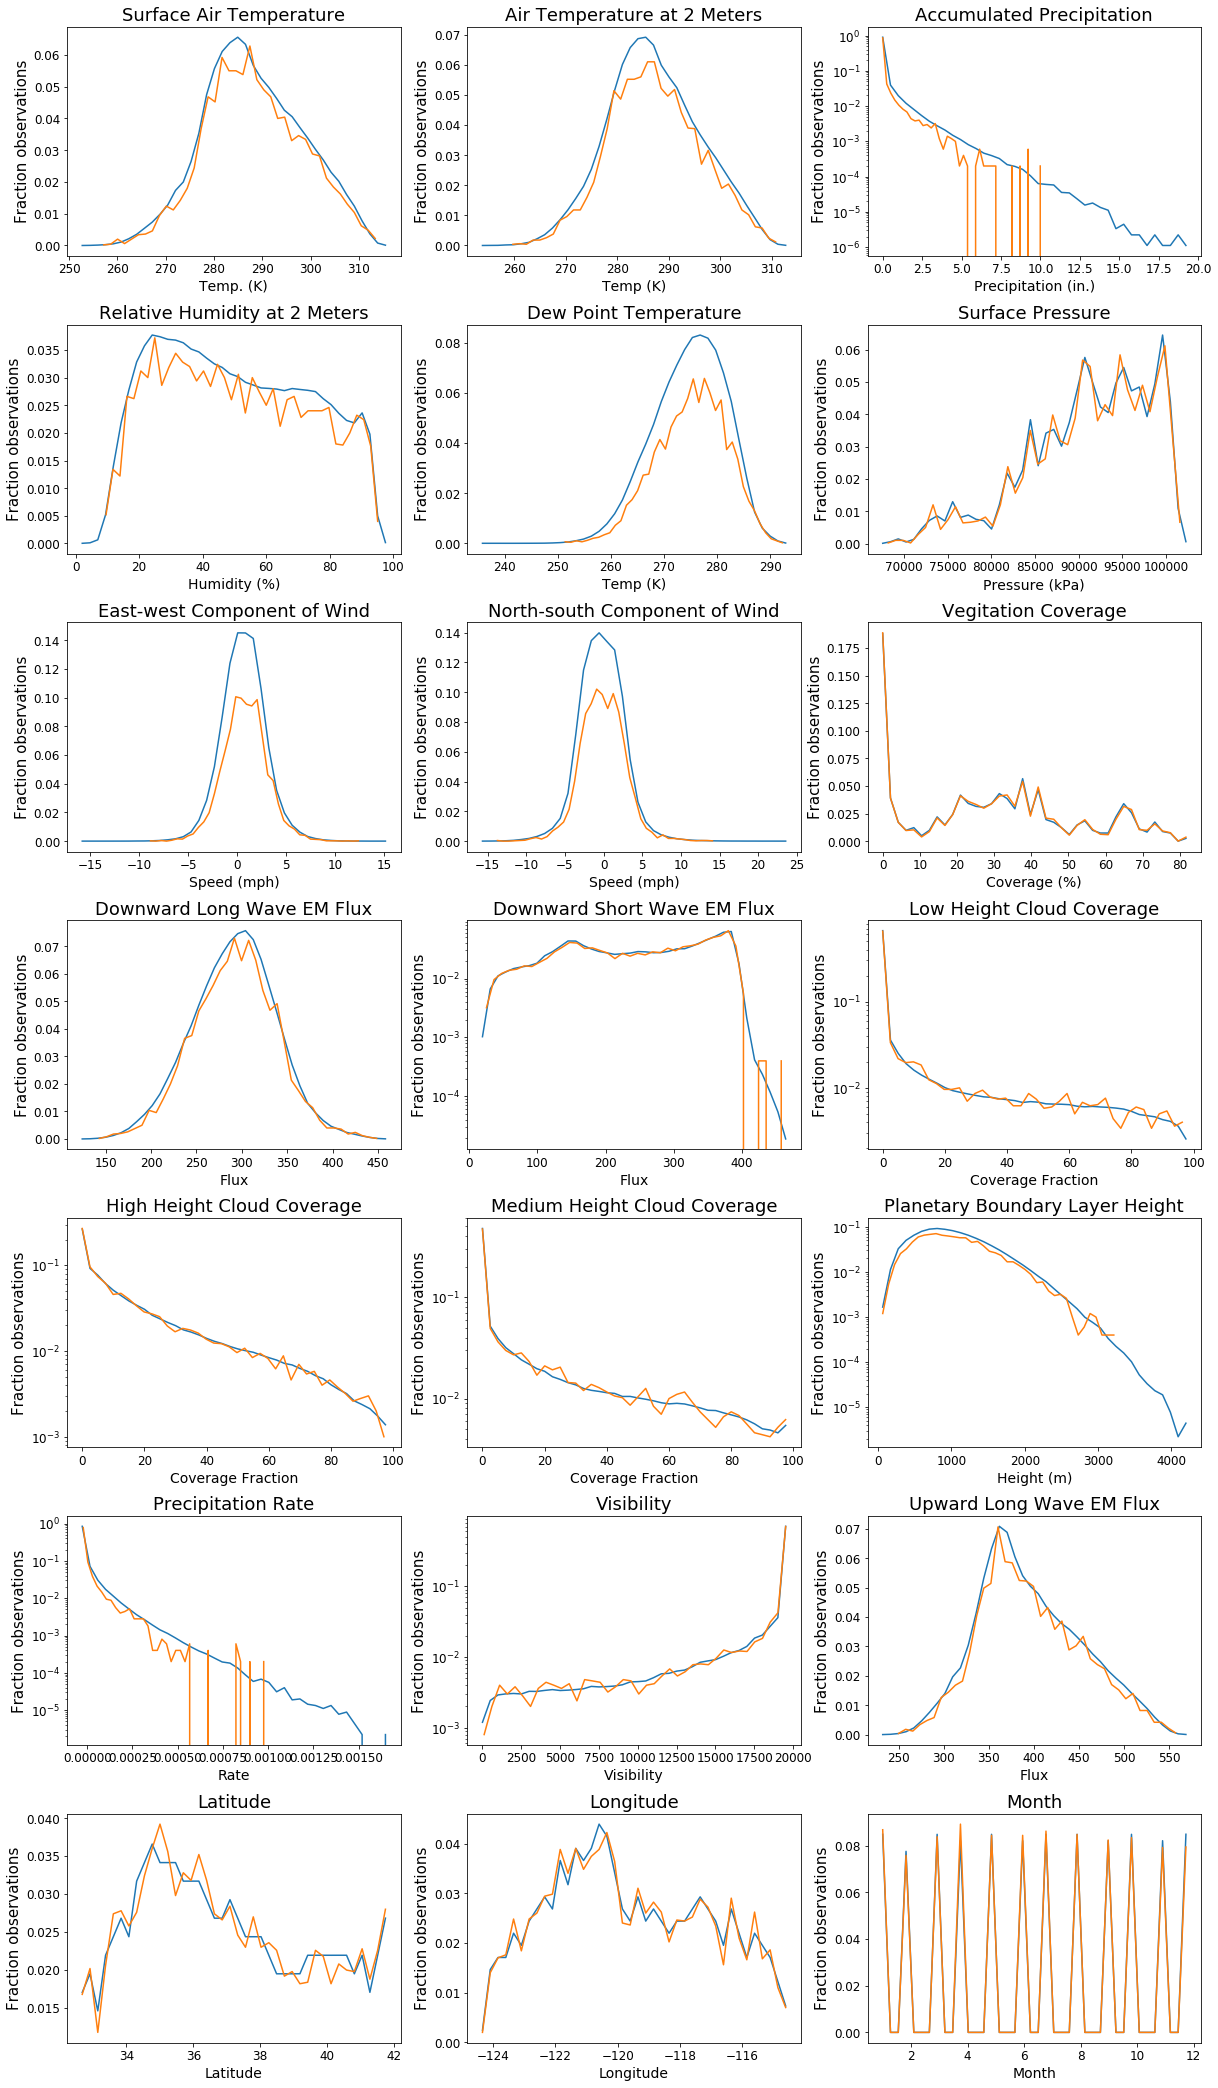

In [8]:
# Make density plots
fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(plot_locations)):
    ax[plot_locations[i]] = two_sample_density_plot(plot_locations[i], data, sample, data_types[i], plot_titles[i], xlabels[i], ylabels[i], y_scales[i])
    
plt.show()

I think we should drill down further and look at the distributions of weather variables for positive and negative observations between the training set and parent set. Since the positive examples are such a small fraction of the total dataset and we are stratifying our sample, we are going to end up with an even smaller number of positive cases in the sample. This makes it more likely that the weather variable distributions will be different.

In [9]:
raw_positive = data[data['ignition'] == 1]
raw_negative = data[data['ignition'] == 0]
sample_positive = sample[sample['ignition'] == 1]
sample_negative = sample[sample['ignition'] == 0]

print("Percent ignitions parent dataset: {}".format(np.round((len(raw_positive)/len(data))*100),3))
print("Percent ignitions sample dataset: {}".format(np.round((len(sample_positive)/len(sample))*100),3))

print("\nTotal ignitions sample dataset: {}".format(len(sample_positive)))

Percent ignitions parent dataset: 7.0
Percent ignitions sample dataset: 7.0

Total ignitions sample dataset: 348


OK, let's run our KS test again, this time comparing sample positives to parent positives.

In [10]:
for variable in weather_variables:
    parent_data = np.array(raw_positive[variable])
    sample = np.array(sample_positive[variable])
    
    ks_result = ks_2samp(parent_data, sample)
    
    print("{} KS test p-value: {}".format(variable, np.round(ks_result[1],3)))

weather_bin_month KS test p-value: 0.767
weather_bin_year KS test p-value: 1.0
air.sfc KS test p-value: 0.252
air.2m KS test p-value: 0.273
apcp KS test p-value: 0.459
crain KS test p-value: 0.994
rhum.2m KS test p-value: 0.079
dpt.2m KS test p-value: 0.863
pres.sfc KS test p-value: 0.886
uwnd.10m KS test p-value: 0.538
vwnd.10m KS test p-value: 0.054
veg KS test p-value: 0.499
dlwrf KS test p-value: 0.115
dswrf KS test p-value: 0.943
lcdc KS test p-value: 0.988
hcdc KS test p-value: 0.818
mcdc KS test p-value: 0.74
hpbl KS test p-value: 0.665
prate KS test p-value: 0.098
vis KS test p-value: 0.727
ulwrf.sfc KS test p-value: 0.33


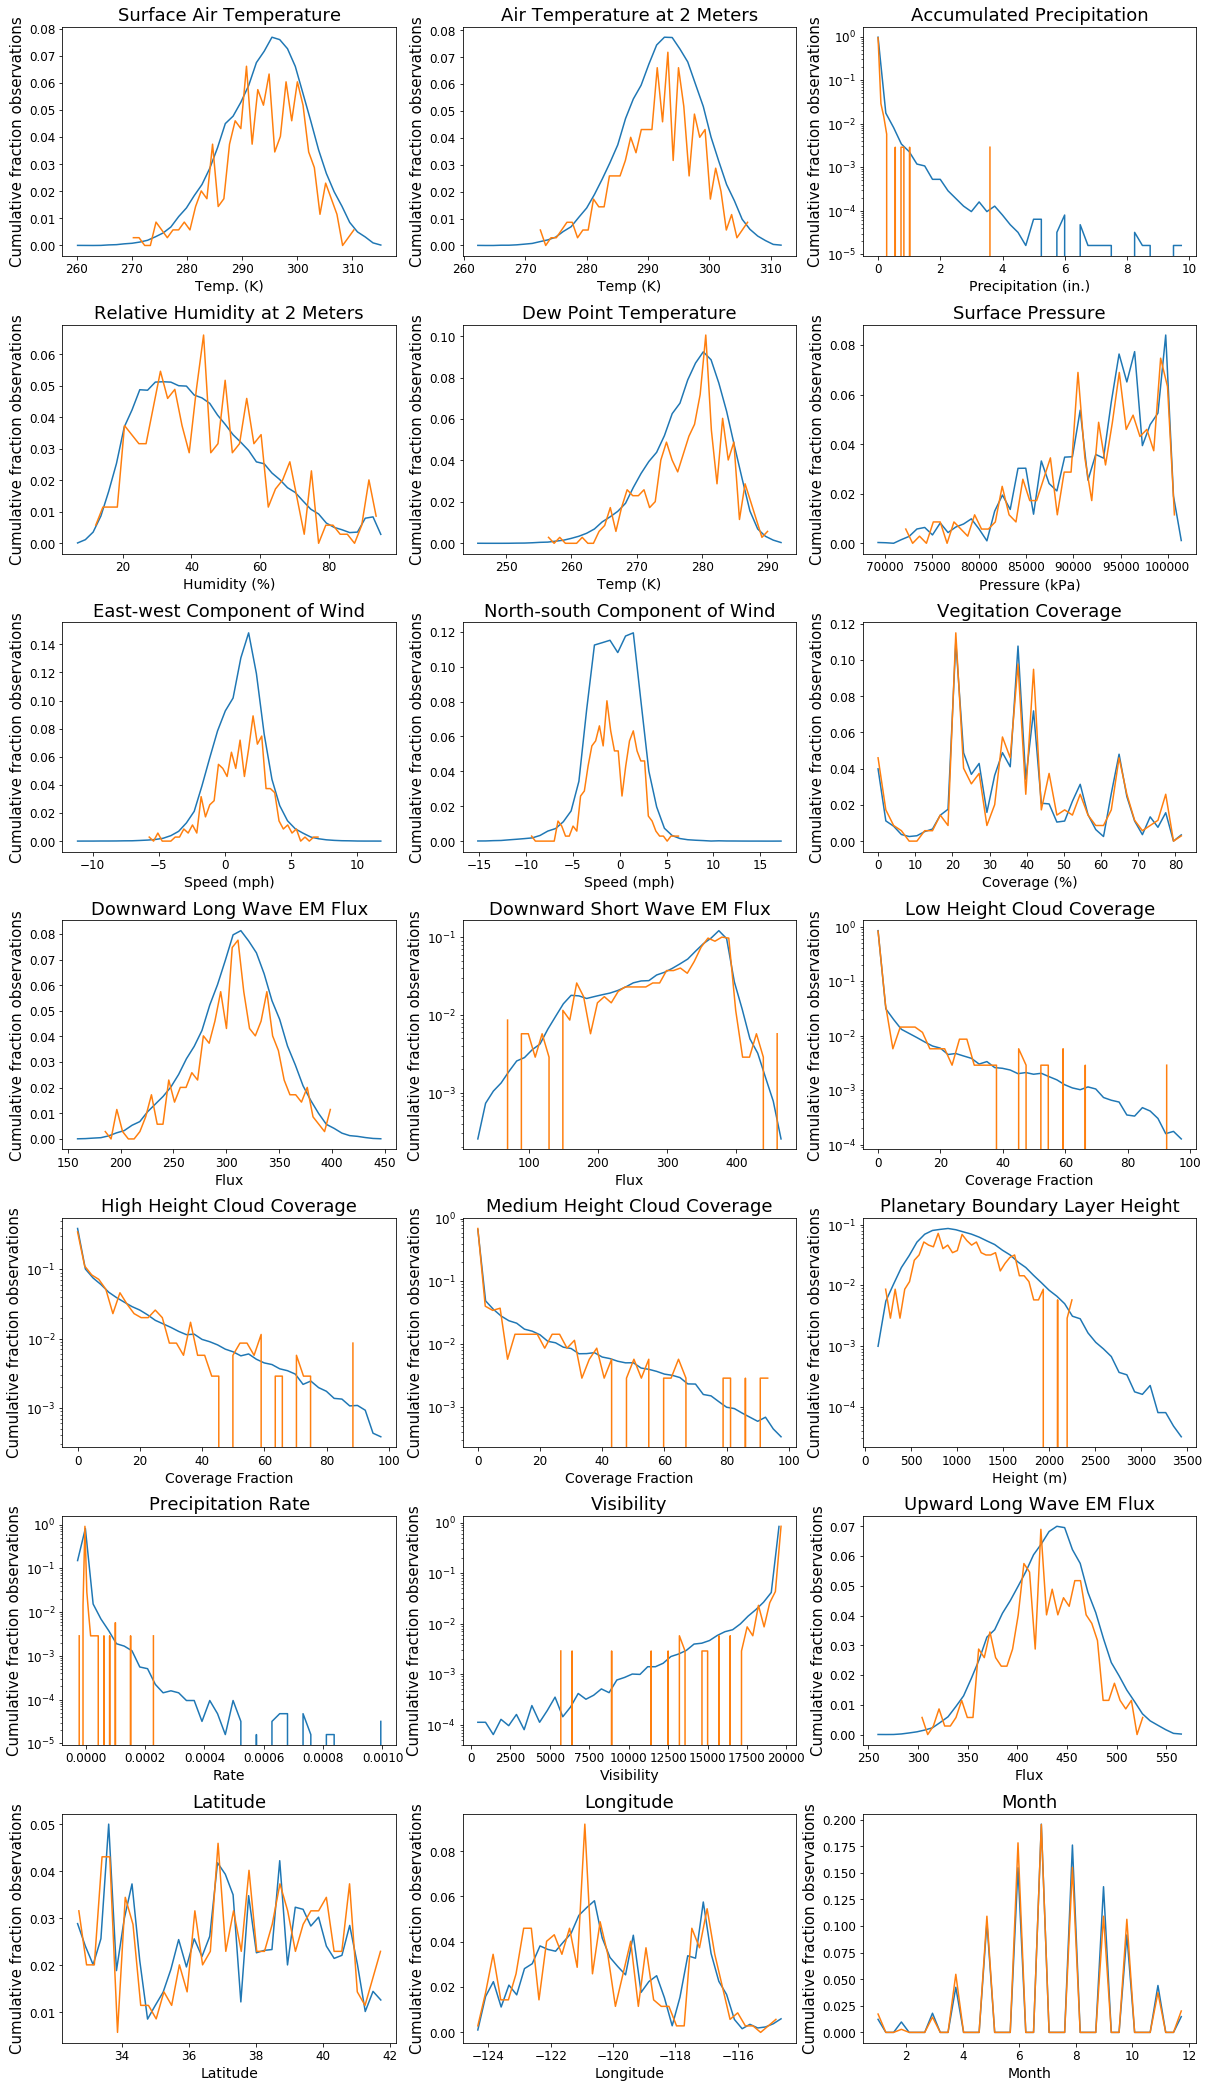

In [11]:
# Make density plots
xlabels = weather_variable_labels
ylabels = ['Cumulative fraction observations'] * len(xlabels)

fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(plot_locations)):
    ax[plot_locations[i]] = two_sample_density_plot(plot_locations[i], raw_positive, sample_positive, data_types[i], plot_titles[i], xlabels[i], ylabels[i], y_scales[i])
    
plt.show()

Maybe not surprisingly these look even more rough. As the sample size gets larger, we might expect this to be less and less of a problem. But let's try stratifying everything anyway... not sure how much it will help, but based on what I have seen, it looks like it is worth a shot. Start using a simple brute force random walk approach.

In [12]:
# Add unique id column
data.insert(0, 'ID', range(0, len(data)))

In [13]:
# Grab starting sample

# make a master copy of the data
master_data = data.copy()

# determine fraction positive observations in master data
fraction_positive = len(master_data[master_data['ignition'] == 1])/len(master_data)

# split positive and negative datsets up
ignitions = data[data['ignition'] == 1]
no_ignitions = data[data['ignition'] == 0]

# Calculate ignition & no ignition sample sizes
ignition_fraction = len(ignitions) / len(data)
ignition_sample_size = int((sample_size * ignition_fraction))
no_ignition_sample_size = int((sample_size * (1 - ignition_fraction)))

# sample data
no_ignitions_sample = k_random_sample(no_ignitions, no_ignition_sample_size)
ignitions_sample = k_random_sample(ignitions, ignition_sample_size)

# combine
sample = no_ignitions_sample.append(ignitions_sample)

# in the first round, our sample is the winning sample
winning_sample = sample.copy()

# get IDs of observations in sample
sample_ids = sample.ID

# remove sample observations from parent dataset
data = data[~data.ID.isin(sample_ids)]

print("Sample ignitions: {}".format(len(sample[sample['ignition']==1])))
print("Sample size: {}".format(len(sample)))

Sample ignitions: 348
Sample size: 4999


In [ ]:
winning_ks_list = []
winning_step_nums = []
old_ks = 0
fraction = 0.001

# itteritivly replace fraction of data and calculate KS statistic, keep winners
for i in range(1000):

    total_ks = cal_KS_total_statistic(master_data, sample, weather_variables)
    
    if total_ks > old_ks:
        # if we win, replace winning sample
        winning_ks_list.append(total_ks)
        winning_step_nums.append(i)
        print("New winner, round {} - total KS statistic: {}".format(i, np.round(total_ks,3)))
        winning_sample = sample
        old_ks = total_ks
        
        # Then resample and move on
        data, sample = replace_sample_subset(sample, fraction, data)
        
    else:
        # If we did not win, go back to our last winner, resample and move on
        sample = winning_sample
        print("Round {} - total KS statistic: {}".format(i, np.round(total_ks,3)))
        data, sample = replace_sample_subset(sample, fraction, data)
#         data_size = len(data)
#         sample_size = len(sample)
#         fraction_positive = len(sample[sample['ignition'] == 1])/len(sample)
#         print('Parent dataset: {}, sample: {}, {}% ignition'.format(data_size, sample_size, np.round((fraction_positive*100), 0)))

New winner, round 0 - total KS statistic: 11.264
Round 1 - total KS statistic: 10.968
Parent dataset: 893749, sample: 4999, 7.0% ignition
Round 2 - total KS statistic: 11.116
Parent dataset: 893749, sample: 4999, 7.0% ignition
Round 3 - total KS statistic: 11.025
Parent dataset: 893749, sample: 4999, 7.0% ignition
Round 4 - total KS statistic: 11.108
Parent dataset: 893749, sample: 4999, 7.0% ignition
New winner, round 5 - total KS statistic: 11.52
New winner, round 6 - total KS statistic: 11.627
Round 7 - total KS statistic: 11.6
Parent dataset: 893749, sample: 4999, 7.0% ignition
Round 8 - total KS statistic: 11.479
Parent dataset: 893749, sample: 4999, 7.0% ignition
Round 9 - total KS statistic: 11.465
Parent dataset: 893749, sample: 4999, 7.0% ignition
Round 10 - total KS statistic: 11.45
Parent dataset: 893749, sample: 4999, 7.0% ignition
New winner, round 11 - total KS statistic: 11.713
Round 12 - total KS statistic: 11.471
Parent dataset: 893749, sample: 4999, 7.0% ignition
New 

Parent dataset: 893749, sample: 4999, 7.0% ignition
Round 113 - total KS statistic: 16.231
Parent dataset: 893749, sample: 4999, 7.0% ignition
Round 114 - total KS statistic: 16.221
Parent dataset: 893749, sample: 4999, 7.0% ignition
Round 115 - total KS statistic: 16.203
Parent dataset: 893749, sample: 4999, 7.0% ignition
Round 116 - total KS statistic: 16.148
Parent dataset: 893749, sample: 4999, 7.0% ignition
Round 117 - total KS statistic: 16.181
Parent dataset: 893749, sample: 4999, 7.0% ignition
Round 118 - total KS statistic: 16.055
Parent dataset: 893749, sample: 4999, 7.0% ignition
Round 119 - total KS statistic: 16.17
Parent dataset: 893749, sample: 4999, 7.0% ignition
Round 120 - total KS statistic: 16.197
Parent dataset: 893749, sample: 4999, 7.0% ignition
Round 121 - total KS statistic: 16.126
Parent dataset: 893749, sample: 4999, 7.0% ignition
New winner, round 122 - total KS statistic: 16.325
Round 123 - total KS statistic: 16.108
Parent dataset: 893749, sample: 4999, 7.

In [ ]:
# Make density plots
xlabels = weather_variable_labels
ylabels = ['Cumulative fraction observations'] * len(xlabels)

fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(plot_locations)):
    ax[plot_locations[i]] = two_sample_density_plot(plot_locations[i], data, winning_sample, data_types[i], plot_titles[i], xlabels[i], ylabels[i], y_scales[i])
    
plt.show()

In [ ]:
for variable in weather_variables:
    parent_data = np.array(data[variable])
    sample = np.array(winning_sample[variable])
    
    ks_result = ks_2samp(parent_data, sample)
    
    print("{} KS test p-value: {}".format(variable, np.round(ks_result[1],3)))